In [2]:
from run import Prepro
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

In [30]:
train_test_split = 0.8 #how much train test data
predict_at = 8 #steps_out
window_size = 8 #how many timesteps from the past to take ie steps_in

#vision_data = np.load('data/vision_data_30_16_120_3years_test2.npy', allow_pickle = True)
vision_data = np.load('data/vision_data_50_20_60_3years_v2.npy', allow_pickle = True)
# vision_data = np.load('../../../Volumes/Samsung_T5/vision_data_50_20_90_1980_v3.npy', allow_pickle = True)
#y = np.load('data/y_30_16_120_3years_test2.npy', allow_pickle = True)
y = np.load('data/y_50_20_60_3years_v2.npy', allow_pickle = True) 
# y = np.load('../../../Volumes/Samsung_T5/y_50_20_90_1980_v3.npy', allow_pickle = True) 
train_tensors, test_tensors = Prepro.process(vision_data, y, train_test_split, predict_at = 8, window_size =  8)
x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3735, 8, 9, 25, 25])
X_stat torch.Size([3735, 8, 10])
target_displacement torch.Size([3735, 8, 2])
target_intensity torch.Size([3735])
target_intensity_cat torch.Size([3735])
target_intensity_cat_baseline torch.Size([3735])
Keeping 3143 samples out of the initial 3735.
Reshaping the displacement target...


In [31]:
x_stat_train[0,1,:]
#'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR', 


#'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
#'STORM_SPEED', 'STORM_DIR', 'storm_category', 'basin_EP', 'basin_NI',
#'basin_SI', 'basin_SP', 'basin_WP', 'nature_DS', 'nature_ET',
#'nature_MX', 'nature_NR', 'nature_SS', 'nature_TS'
#'STORM CATEGORY', 
#'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y'

tensor([ 6.8000e+00, -1.7200e+02,  5.5000e+01,  9.9400e+02,  2.1470e+03,
         8.0000e+00,  3.2100e+02,  1.0000e+00,  4.1247e-01, -3.0800e-01])

In [32]:
tgt_displacement_train.shape

torch.Size([2514, 2])

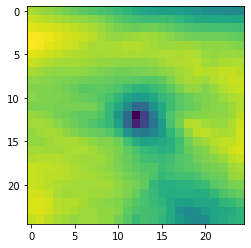

In [33]:
plt.imshow(x_viz_train[20,7,7])

In [34]:
x_viz_train.shape
#samples * timesteps * number of maps * size of map * size of map

torch.Size([2514, 8, 9, 25, 25])

In [35]:
x_stat_train.shape
#samples * number of past timesteps * number of features

torch.Size([2514, 8, 10])

In [42]:
y.shape
#number of storms * number of timesteps * number of features

(83, 60, 11)

In [43]:
X_train = x_stat_train.reshape(x_stat_train.shape[0], -1)
X_test = x_stat_test.reshape(x_stat_test.shape[0], -1)
X_train.shape

torch.Size([2514, 80])

In [44]:
X_train_vision = x_viz_train.reshape(x_viz_train.shape[0], -1)
X_test_vision = x_viz_test.reshape(x_viz_test.shape[0], -1)
print(X_train_vision.shape)
print(X_test_vision.shape)

torch.Size([2514, 45000])
torch.Size([629, 45000])


In [39]:
X_train_tab_vision = np.concatenate((X_train, X_train_vision), axis = 1)
X_test_tab_vision = np.concatenate((X_test, X_test_vision), axis = 1)

In [40]:
print(tgt_intensity_cat_train.shape)
print(tgt_intensity_cat_test.shape)

torch.Size([2514])
torch.Size([629])


In [41]:
xgb = XGBClassifier(max_depth=5, n_estimators=80)
xgb.fit(X_train, tgt_intensity_cat_train)
yhat = xgb.predict(X_test)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

XGB score 0.5405405405405406
Baseline score 0.45151033386327505


In [45]:
xgb = XGBClassifier(max_depth=6, n_estimators=200)
xgb.fit(X_train_tab_vision, tgt_intensity_cat_train)
yhat = xgb.predict(X_test_tab_vision)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

KeyboardInterrupt: 

In [ ]:
xgb = XGBClassifier(max_depth=4, n_estimators=80)
xgb.fit(X_train_vision, tgt_intensity_cat_train)
yhat = xgb.predict(X_test_vision)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

In [55]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, tgt_intensity_cat_train)
yhat = rf.predict(X_test)
print("RF score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

RF score 0.8814372999709048
Baseline score 0.8910386965376782


In [68]:
xgb_x = XGBRegressor(max_depth=3, n_estimators=80)
xgb_y = XGBRegressor(max_depth=3, n_estimators=80)
xgb_x.fit(X_train, tgt_displacement_train[:,0])
xgb_y.fit(X_train, tgt_displacement_train[:,1])

yhat_x = xgb_x.predict(X_test)
yhat_y = xgb_y.predict(X_test)
print("XGB x score", mean_absolute_error(tgt_displacement_test[:,0], yhat_x))
print("XGB y score", mean_absolute_error(tgt_displacement_test[:,1], yhat_y))
#be careful for interpretation because the displacement is in degree + standardized + I did not code any baseline

[22:10:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB x score 0.34135345
XGB y score 0.33949062


In [69]:
tgt_displacement_train.max()

tensor(4.7578)

In [74]:
tgt_displacement_train[:,0].std()

tensor(1.0000)

In [ ]:
def run_models(steps_in, steps_out, max_depth=5):
    train_test_split = 0.8
    predict_at = steps_in #steps_out
    window_size= steps_out #how many timesteps from the past to take ie steps_in

    train_tensors, test_tensors = Prepro.process(vision_data, y, train_test_split, predict_at, window_size)
    x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
    x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

    #reshape and concat
    X_train = x_stat_train.reshape(x_stat_train.shape[0], -1)
    X_test = x_stat_test.reshape(x_stat_test.shape[0], -1)
    X_train_vision = x_viz_train.reshape(x_viz_train.shape[0], -1)
    X_test_vision = x_viz_test.reshape(x_viz_test.shape[0], -1)
    X_train_tab_vision = np.concatenate((X_train, X_train_vision), axis = 1)
    X_test_tab_vision = np.concatenate((X_test, X_test_vision), axis = 1)

    #run xgb for intensity
    xgb = XGBClassifier(max_depth, n_estimators=100)
    xgb.fit(X_train, tgt_intensity_cat_train)
    intensity_xgb = xgb.predict(X_test)

    #run random forrest for intensity
    rf = RandomForestClassifier(n_estimators=200)
    rf.fit(X_train, tgt_intensity_cat_train)
    intensity_rf = rf.predict(X_test)

    #run xbg for displacement x and y
    xgb_x = XGBRegressor(max_depth, n_estimators=100)
    xgb_y = XGBRegressor(max_depth, n_estimators=100)
    xgb_x.fit(X_train, tgt_displacement_train[:,0])
    xgb_y.fit(X_train, tgt_displacement_train[:,1])

    dx_xgb= xgb_x.predict(X_test)
    dy_xgb= xgb_y.predict(X_test)

    # #calculate accuracy score for intensity
    intensity_xgb_score = accuracy_score(tgt_intensity_cat_test, intensity_xgb).round(3)
    intensity_rf_score = accuracy_score(tgt_intensity_cat_test, intensity_rf).round(3)
    intensity_base_score = accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test).round(3)

    #calculate displacement mae
    dx_xgb_mae =  mean_absolute_error(tgt_displacement_test[:,0], dx_xgb).round(3)
    dy_xgb_mae = mean_absolute_error(tgt_displacement_test[:,1], dy_xgb).round(3)

    return intensity_xgb_score, intensity_rf_score, intensity_base_score, dx_xgb_mae, dy_xgb_mae


In [ ]:
#load data:
#vision_data = np.load('data/vision_data_30_16_120_3years_test2.npy', allow_pickle = True)
vision_data = np.load('data/vision_data_50_20_60_3years_v2.npy', allow_pickle = True)
# vision_data = np.load('../../../Volumes/Samsung_T5/vision_data_50_20_90_1980_v3.npy', allow_pickle = True)

#y = np.load('data/y_30_16_120_3years_test2.npy', allow_pickle = True)
y = np.load('data/y_50_20_60_3years_v2.npy', allow_pickle = True)
# y = np.load('../../../Volumes/Samsung_T5/y_50_20_90_1980_v3.npy', allow_pickle = True)

#set up empty dataframes
accuracy = pd.DataFrame(columns={})

#prediction steps
steps_out_list= [2] #[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

#max_depth
max_depth_list = [4,5]

#steps_in
steps_in_list = [8]

for max_depth in max_depth_list:
    for steps_in in steps_in_list:
        for steps_out in steps_out_list:
            #run model
            intensity_xgb_score, intensity_rf_score, intensity_base_score, dx_xgb_mae, dy_xgb_mae = run_models(steps_in, steps_out, max_depth)
            #record accuracy
            accuracy = accuracy.append({'past_n_steps': str(steps_in),
                                              'pred_n_steps': str(t),
                                              'max_depth': str(max_depth),
                                              'xgb_intensity_accu': intensity_xgb_score,
                                              'rf_intensity_accu': intensity_rf_score,
                                              'base_intensity_accu': intensity_base_score,
                                              'dx_xgb_mae':dx_xgb_mae,
                                              'dy_xgb_mae':dy_xgb_mae}, ignore_index=True)

#output results df
accuracy.to_csv('cluster_results/model_accuracy.csv', index=False)